In [1]:
import json, os, itertools, re
from collections import defaultdict
import gurobipy as gp
import pandas as pd
import numpy as np

In [ ]:
BASE_DIR = r"D:\MINJI\NETWORK RELIABILITY\QGIS\8.UK\json"
edge_fp   = os.path.join(BASE_DIR, "edges_uk_timestep10.json")
route_fp  = os.path.join(BASE_DIR, "routes_nodes_uk.json")
demand_fp = os.path.join(BASE_DIR, "demand_uk.json")
dept_fp   = os.path.join(BASE_DIR, "dep_time_uk.json")


T = 72
max_wait = 4

# CAPACITY = 3
CAPACITY_EDGE = 20
CAPACITY_NODE = 20

failed_edges = {"e59","e59r"}
BIG_M = 10**6
SINK  = "SINK"
DWELL_MIN   = 1

FAIL_T   = 48
T_clear  = 96


with open(edge_fp, encoding="utf-8") as f:
    edges_raw = json.load(f)
edges = {eid: (src, dst, int(tau)) for eid, (src, dst, tau) in edges_raw.items()}

with open(route_fp, encoding="utf-8") as f:
    routes_nodes = json.load(f)

with open(dept_fp, encoding="utf-8") as f:
    dep_time = {tr: int(t) for tr, t in json.load(f).items()}

with open(demand_fp, encoding="utf-8") as f:
    dem_raw = json.load(f)
demand = {tr: [(o, d, float(q)) for o, d, q in lst] for tr, lst in dem_raw.items()}

trains = list(routes_nodes)
nodes  = {n for _, (s, d, _) in edges.items() for n in (s, d)}
nodes.add(SINK)


In [3]:
def route_prefix(tr_id: str) -> str: # e.g. "A1234_1" -> "A"
    m = re.match(r'^([^\d]+)\d+_\d+$', tr_id)
    return m.group(1) if m else tr_id.rsplit('_', 1)[0]


def travel_time_only(path, edges): 
    total = 0
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        total += edges[eid][2]
    return total


def build_sched(routes_nodes, edges, dep_time, DWELL_MIN):
    """
    sched = {
  "A1234_1": {
    "A": {"arr": 10, "dep": 10},
    "B": {"arr": 12, "dep": 13},  # A→B(2 min) 
    "C": {"arr": 16, "dep": 16}   # B→C(3 min)
  },
    """
    sched = {}
    for tr, path in routes_nodes.items():
        t = dep_time[tr]
        arr = {path[0]: {"arr": t, "dep": t}}
        for i, (u, v) in enumerate(zip(path[:-1], path[1:])):
            eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
            travel = edges[eid][2]
            t += travel
            arr[v] = {"arr": t, "dep": t}
            if i < len(path) - 2:
                arr[v]["dep"] += DWELL_MIN
                t += DWELL_MIN
        sched[tr] = arr
    return sched

sched = build_sched(routes_nodes, edges, dep_time, DWELL_MIN)


node_pos = {tr: {n:i for i,n in enumerate(path)} for tr, path in routes_nodes.items()}
edge_tau = { (s,d): tau for _, (s,d,tau) in edges.items() }

def od_distance_on_planned(tr, o, d):
    path = routes_nodes[tr]
    pos = node_pos[tr]
    if o not in pos or d not in pos or pos[o] >= pos[d]:
        return 0.0
    dist = 0.0
    for i in range(pos[o], pos[d]):
        u, v = path[i], path[i+1]
        dist += edge_tau.get((u,v), 0.0)
    return float(dist)

d_rd = {}      # (tr,o,d) -> d
qd_rd = {}     # (tr,o,d) -> q*d
for tr in trains:
    for (o, d, q) in demand[tr]:
        dd = od_distance_on_planned(tr, o, d)
        d_rd[(tr,o,d)] = dd
        qd_rd[(tr,o,d)] = q * dd

print(d_rd, qd_rd)


from collections import defaultdict as DD
by_route = DD(list)
"""
by_route = {
  "A1234": ["A1234_1", "A1234_2"],
}
"""
for tr in trains:
    by_route[route_prefix(tr)].append(tr)


route_runtime = {}
"""
# without dwell time
route_runtime = {
  "A1234": 2 + 3,   # A→B(2) + B→C(3) = 5
}
"""
for rname, tr_list in by_route.items():
    reps = [tr for tr in tr_list if re.fullmatch(re.escape(rname) + r'\d+_1', tr)]
    if not reps:
        reps = [tr for tr in tr_list if tr.endswith('_1')]
    if not reps:
        reps = [sorted(tr_list)[0]]
    rep = reps[0]
    base_run = travel_time_only(routes_nodes[rep], edges)
    route_runtime[rname] = base_run


PADDING_BASE = 6
T_limit = {}
for tr in trains:
    L = len(routes_nodes[tr]) - 1
    dwell_need = max(0, L-1) * DWELL_MIN
    base_run = route_runtime[route_prefix(tr)]
    T_limit[tr] = min(T, dep_time[tr] + base_run + dwell_need + PADDING_BASE)


q_r = {tr: sum(q for *_, q in demand[tr]) for tr in trains}


uv2eid = {} # (u,v) -> eid
dup_keys = set()
for eid, (s, d, _) in edges.items():
    key = (s, d)
    if key in uv2eid and uv2eid[key] != eid:
        dup_keys.add(key)
    else:
        uv2eid[key] = eid
if dup_keys:
    print(f"[warn] multiple eids share the same (u,v): {sorted(list(dup_keys))[:5]} ...")


def planned_eids_of(tr):
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = uv2eid.get((u, v))
        if eid is None:
            raise KeyError(f"No edge (u={u} -> v={v}) in edges; check routes_nodes or edges.json")
        eids.append(eid)
    return eids

planned_eids = {tr: planned_eids_of(tr) for tr in trains}
blocked = {tr: int(any(e in failed_edges for e in planned_eids[tr])) for tr in trains}
T_aff = [tr for tr in trains if blocked[tr] == 1]
T_ok  = [tr for tr in trains if blocked[tr] == 0]


def get_arrival(tr, node, default=10**9):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("arr" in e):
        return e["arr"]
    return default

allow_stop = {}
reach = {}

for tr in trains:
    path = routes_nodes[tr]
    eids = planned_eids[tr]
    L = len(path) - 1  

    last_node = path[-1]
    t_arrival_last = get_arrival(tr, last_node, default=10**9)
    reach[tr] = int(t_arrival_last <= T_limit[tr])

    first_fail = next((idx for idx, e in enumerate(eids) if e in failed_edges), None)

    for i in range(1, L + 1):  
        n = path[i]

        if i == L:
            allow = 1  
        elif reach[tr] == 0:
            allow = 1  
        else:
            if first_fail is not None and i >= (first_fail + 1):
                allow = 1
            else:
                allow = 0

        allow_stop[(tr, n)] = int(allow)

{('1AWC1_1', 'n46', 'n35'): 5.0, ('1AWC1_1', 'n46', 'n31'): 9.0, ('1AWC1_1', 'n46', 'n30'): 10.0, ('1AWC1_1', 'n46', 'n26'): 14.0, ('1AWC1_1', 'n46', 'n24'): 16.0, ('1AWC1_1', 'n46', 'n20'): 18.0, ('1AWC1_1', 'n46', 'n15'): 23.0, ('1AWC1_1', 'n35', 'n31'): 4.0, ('1AWC1_1', 'n35', 'n30'): 5.0, ('1AWC1_1', 'n35', 'n26'): 9.0, ('1AWC1_1', 'n35', 'n24'): 11.0, ('1AWC1_1', 'n35', 'n20'): 13.0, ('1AWC1_1', 'n35', 'n15'): 18.0, ('1AWC1_1', 'n31', 'n30'): 1.0, ('1AWC1_1', 'n31', 'n26'): 5.0, ('1AWC1_1', 'n31', 'n24'): 7.0, ('1AWC1_1', 'n31', 'n20'): 9.0, ('1AWC1_1', 'n31', 'n15'): 14.0, ('1AWC1_1', 'n30', 'n26'): 4.0, ('1AWC1_1', 'n30', 'n24'): 6.0, ('1AWC1_1', 'n30', 'n20'): 8.0, ('1AWC1_1', 'n30', 'n15'): 13.0, ('1AWC1_1', 'n26', 'n24'): 2.0, ('1AWC1_1', 'n26', 'n20'): 4.0, ('1AWC1_1', 'n26', 'n15'): 9.0, ('1AWC1_1', 'n24', 'n20'): 2.0, ('1AWC1_1', 'n24', 'n15'): 7.0, ('1AWC1_1', 'n20', 'n15'): 5.0, ('1AWC1_2', 'n46', 'n35'): 5.0, ('1AWC1_2', 'n46', 'n31'): 9.0, ('1AWC1_2', 'n46', 'n30'): 10

In [4]:
CROSS = {}
"""
CROSS[tr] = (u, v, eid, t0, t1)

# CROSS stores arcs where FAIL_T lies inside (t0, t1]:
- 45–55 arc → stored (train is on arc during FAIL_T)
- 30–50 arc → stored (train arrives exactly at FAIL_T)

e.g.
CROSS = {
  "A1234_1": ("S", "M", "e10", 30, 50),  
}
"""
for tr in trains:
    path = routes_nodes[tr]
    t = dep_time[tr]
    for u, v in zip(path[:-1], path[1:]):
        eid = uv2eid[(u, v)]
        tau = edges[eid][2]
        t0, t1 = t, t + tau
        if t0 < FAIL_T <= t1:
            CROSS[tr] = (u, v, eid, t0, t1)
            break
        t = t1
        if v != path[-1]:
            t += DWELL_MIN

In [5]:
def sched_arr(tr, node, default=None):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("arr" in e):
        return e["arr"]
    return default


def initial_snapshot_at_FAIL_T():
    start_node, start_time = {}, {}
    """
    - If FAIL_T crosses an arc for train tr:
    start_node[tr] = arrival node of that arc
    start_time[tr] = arrival time t1

    - Else:
    pick the latest node with planned arr <= FAIL_T
    start_node[tr] = node
    start_time[tr] = max(FAIL_T, that arrival time)  # effectively FAIL_T

    - If nothing arrived yet (depart x):
    start_node[tr] = origin node (path[0])
    start_time[tr] = max(FAIL_T, dep_time[tr])
    """

    for tr in trains:
        if tr in CROSS:
            _, v, _, _, t1 = CROSS[tr]
            start_node[tr] = v
            start_time[tr] = t1
        else:
            path = routes_nodes[tr]
            cand = []
            for n in path:
                ta = sched_arr(tr, n)
                if ta is not None and ta <= FAIL_T:
                    cand.append((ta, n))
            if cand:
                ta, n = max(cand)
                start_node[tr] = n
                start_time[tr] = max(FAIL_T, ta)
            else:
                start_node[tr] = path[0]
                start_time[tr] = max(FAIL_T, dep_time[tr])
    return start_node, start_time

start_node, start_time = initial_snapshot_at_FAIL_T()

print("start_node:", start_node)
print("start_time:", start_time)


start_node: {'1AWC1_1': 'n15', '1AWC1_2': 'n15', '1AWC1_3': 'n15', '1AWC1_4': 'n15', '1AWC1_5': 'n15', '1AWC1_6': 'n15', '1AWC1_7': 'n15', '1AWC1_8': 'n15', '1AWC1_9': 'n20', '1AWC1_10': 'n24', '1AWC1_11': 'n26', '1AWC1_12': 'n26', '1AWC1_13': 'n30', '1AWC1_14': 'n31', '1AWC2_1': 'n46', '1AWC2_2': 'n46', '1AWC2_3': 'n26', '1EMR1_1': 'n20', '1EMR1_2': 'n20', '1EMR1_3': 'n20', '1EMR1_4': 'n20', '1EMR1_5': 'n20', '1EMR1_6': 'n20', '1EMR1_7': 'n20', '1EMR1_8': 'n20', '1EMR1_9': 'n20', '1EMR1_10': 'n20', '1EMR1_11': 'n20', '1EMR1_12': 'n21', '1EMR1_13': 'n21', '1EMR1_14': 'n22', '1EMR1_15': 'n27', '1EMR1_16': 'n27', '1EMR1_17': 'n46', '1EMR2_1': 'n46', '1EMR2_2': 'n46', '1EMR2_3': 'n27', '1GA1_1': 'n28', '1GA1_2': 'n28', '1GA1_3': 'n28', '1GA1_4': 'n28', '1GA1_5': 'n28', '1GA1_6': 'n28', '1GA1_7': 'n28', '1GA1_8': 'n29', '1GA1_9': 'n29', '1GA1_10': 'n29', '1GA1_11': 'n33', '1GA1_12': 'n33', '1GA2_1': 'n46', '1GA2_2': 'n39', '1GWR1_1': 'n40', '1GWR1_2': 'n40', '1GWR1_3': 'n40', '1GWR1_4': 'n

In [6]:
def build_arc_list_window(t_start, t_end, failed_edges, T_clear, max_wait,
                          nodes, edges, CROSS):
    arc_list = []
    for eid, (src, dst, tau) in edges.items():  # travel arcs
        for t in range(t_start, min(t_end, T + 1 - tau)):
            is_cross_whitelist = False
            for _, (_, _, e0, t0, t1) in CROSS.items():
                if e0 == eid and t == t0:
                    is_cross_whitelist = (t0 < FAIL_T <= t1)
            if (eid in failed_edges) and (t < T_clear) and (not is_cross_whitelist):
                continue
            arc_list.append((f"{src}^{t}", f"{dst}^{t+tau}", eid, tau, t, t+tau))

    for n in nodes - {SINK}: # wait arcs
        for w in range(1, max_wait+1):
            for t in range(t_start, min(t_end, T + 1 - w)):
                arc_list.append((f"{n}^{t}", f"{n}^{t+w}", f"w_{n}_{w}", w, t, t+w))

    for n in nodes - {SINK}: # dummy arcs
        for t in range(t_start, min(t_end, T+1)):
            arc_list.append((f"{n}^{t}", f"{SINK}^{t}", f"dummy_{n}", 0, t, t))


    arc_idx = {info: i for i, info in enumerate(arc_list)}
    eid_to_arcidx = defaultdict(list)
    dummy_idx_of  = defaultdict(list)
    wait_idx_of   = defaultdict(list)
    for k, (_, _, eid, *_) in enumerate(arc_list):
        s_eid = str(eid)
        if s_eid.startswith("dummy_"):
            n = s_eid.split("dummy_", 1)[1]
            dummy_idx_of[n].append(k) # dummy 아크면 해당 노드 key에 아크 인덱스 추가
        elif s_eid.startswith("w_"):
            parts = s_eid.split("_", 2)
            if len(parts) >= 3:
                n = parts[1]
                wait_idx_of[n].append(k) # wait 아크면 노드 key에 아크 인덱스 추가
        else:
            eid_to_arcidx[eid].append(k) # eid key에 아크 인덱스 추가


    # (node, time) in/out adjacency lists
    out_arcs = defaultdict(list) 
    in_arcs  = defaultdict(list)
    node_in_arcs  = defaultdict(list) 
    node_out_arcs = defaultdict(list)

    for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
        n_fr, tt_fr = fr.split("^"); tt_fr = int(tt_fr)
        n_to, tt_to = to.split("^"); tt_to = int(tt_to)
        out_arcs[(n_fr, tt_fr)].append(k)
        in_arcs [(n_to, tt_to)].append(k)

        s_eid = str(eid)                   
        if not s_eid.startswith(("w_", "dummy")):
            node_out_arcs[n_fr].append(k)
            node_in_arcs [n_to].append(k)


    # (eid, time slot) list arcs occupying it
    cap_map = defaultdict(list)
    for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
        if str(eid).startswith(("w_", "dummy")):
            continue
        for tt in range(max(t0, t_start), min(t1, t_end)):
            cap_map[(eid, tt)].append(k)
    for tr, (u, v, e0, t0, t1) in CROSS.items():
        if (t0 < FAIL_T <= t1):
            for tt in range(max(FAIL_T, t_start), min(t1, t_end)):
                cap_map[(e0, tt)].append(-1)  # -1: ghost occupancy


    return {
        "arc_list": arc_list,
        "arc_idx": arc_idx,
        "eid_to_arcidx": eid_to_arcidx,
        "dummy_idx_of": dummy_idx_of,
        "wait_idx_of": wait_idx_of,
        "out_arcs": out_arcs,
        "in_arcs": in_arcs,
        "cap_map": cap_map,
        "node_out_arcs": node_out_arcs,  
        "node_in_arcs": node_in_arcs,    
    }

In [7]:
def build_model_window(window_ctx, t_start, t_end,
                       start_node, start_time,
                       planned_eids, routes_nodes,
                       T_aff, T_ok, allow_stop, T_limit):

    arc_list      = window_ctx["arc_list"]
    eid_to_arcidx = window_ctx["eid_to_arcidx"]
    dummy_idx_of  = window_ctx["dummy_idx_of"]
    out_arcs      = window_ctx["out_arcs"]
    in_arcs       = window_ctx["in_arcs"]
    node_out_arcs = window_ctx["node_out_arcs"]
    node_in_arcs  = window_ctx["node_in_arcs"]


    m = gp.Model(); m.Params.OutputFlag = 1
    nA, nT = len(arc_list), len(trains)

    enabled_pairs = []
    for ti, tr in enumerate(trains):
        P_eids = set(planned_eids[tr])
        for k, (_, to, eid, tau, t0, t1) in enumerate(arc_list):
            s_eid = str(eid)

            # 1) 더미 종료는 allow_stop로 제한
            if s_eid.startswith("dummy_"):
                n_to = s_eid.split("dummy_", 1)[1]
                if allow_stop.get((tr, n_to), 1) == 0:
                    continue
                enabled_pairs.append((k, ti))
                continue

            # 2) 대기는 허용
            if s_eid.startswith("w_"):
                enabled_pairs.append((k, ti))
                continue

            # 3) 실제 선로 아크
            if tr in T_ok:
                if eid not in P_eids:
                    continue

            enabled_pairs.append((k, ti))


    x = m.addVars(enabled_pairs, vtype=gp.GRB.BINARY, name="x")
    t_arr = {(tr, n): m.addVar(lb=0, ub=T, vtype=gp.GRB.CONTINUOUS, name=f"tarr[{tr},{n}]")
             for tr in trains for n in nodes - {SINK}}
    delta = {(tr,o,d): m.addVar(lb=0, name=f"delta[{tr},{o},{d}]")
             for tr in trains for (o,d,_) in demand[tr]}


    gamma = {(tr,o,d): m.addVar(lb=0.0, ub=1.0, vtype=gp.GRB.CONTINUOUS,
                                name=f"gamma[{tr},{o},{d}]")
            for tr in trains for (o,d,_) in demand[tr]}
    x_pts = [0, 3, 6, 12, 24]     # delay minutes
    y_pts = [0, 0.25, 0.50, 0.75, 1] # refund ratio
    for tr in trains:
        for (o,d,_) in demand[tr]:
            m.addGenConstrPWL(delta[(tr,o,d)], gamma[(tr,o,d)], x_pts, y_pts,
                            name=f"pwl_gamma[{tr},{o},{d}]")


    h = {}
    y = {}
    s = {}
    z = {}
    u_eid = {}

    if T_aff:
        h = m.addVars(T_aff, vtype=gp.GRB.BINARY, name="h")
        y = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"y[{tr},{n}]")
             for tr in T_aff for n in routes_nodes[tr][1:]}
        s = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"s[{tr},{n}]")
             for tr in T_aff for n in nodes - {SINK}}
        z = {(tr,o,d): m.addVar(vtype=gp.GRB.BINARY, name=f"z[{tr},{o},{d}]")
             for tr in T_aff for (o,d,_) in demand[tr]}

        # 우회 허용: 계획에 없는 eid만 u_eid 생성 + x ≤ u_eid 
        real_eids = {eid for (_,_,eid,_,_,_) in arc_list if not str(eid).startswith(("w_","dummy"))}
        for tr in T_aff:
            P = set(planned_eids[tr])
            for eid in real_eids:
                if eid in P: continue
                u_eid[(tr, eid)] = m.addVar(vtype=gp.GRB.BINARY, name=f"u_eid[{tr},{eid}]")
                for k in eid_to_arcidx[eid]:
                    ti = trains.index(tr)
                    m.addConstr(x[k, ti] <= u_eid[(tr, eid)])


    def sum_x(tr_i, idxs):
        return gp.quicksum(x[k, tr_i] for k in idxs if (k, tr_i) in x)

    for tr_i, tr in enumerate(trains): # no same arc usage by same train
        for eid, idxs in eid_to_arcidx.items():
            m.addConstr(sum_x(tr_i, idxs) <= 1, name=f"L0[{tr},{eid}]")


    # flow conservation const.
    for tr in trains:
        tr_i = trains.index(tr)

        r_o   = routes_nodes[tr][0]
        t_dep = dep_time[tr]
        n0, t0 = start_node[tr], start_time[tr]
        src_t  = max(t0, t_start)

        out_dep_en = [k for k in out_arcs.get((r_o, t_dep), []) if (k, tr_i) in x]
        in_dep_en  = [k for k in  in_arcs.get((r_o, t_dep), []) if (k, tr_i) in x]

        can_anchor_at_origin = (t_start <= t_dep < t_end) and (len(out_dep_en)+len(in_dep_en) > 0)
        #dep_is_post_incident = (t_dep >= FAIL_T)

        if can_anchor_at_origin:
            rhs = h[tr] if tr in T_aff else 1 
            m.addConstr(gp.quicksum(x[k, tr_i] for k in out_dep_en)
                        - gp.quicksum(x[k, tr_i] for k in in_dep_en) == rhs,
                        name=f"src_origin[{tr},{r_o},{t_dep}]")

        else:
            out_snap_en = [k for k in out_arcs.get((n0, src_t), []) if (k, tr_i) in x]
            in_snap_en  = [k for k in  in_arcs.get((n0, src_t), []) if (k, tr_i) in x]
            if len(out_snap_en) + len(in_snap_en) > 0:
                m.addConstr(gp.quicksum(x[k, tr_i] for k in out_snap_en)
                            - gp.quicksum(x[k, tr_i] for k in in_snap_en) == 1,
                            name=f"src_snapshot[{tr},{n0},{src_t}]")

        for t in range(t_start, t_end):
            for n in nodes - {SINK}:
                if can_anchor_at_origin and (n == r_o) and (t == t_dep):
                    continue
                if (not can_anchor_at_origin) and (n == n0) and (t == src_t):
                    continue

                in_idxs  = in_arcs.get((n, t), [])
                out_idxs = out_arcs.get((n, t), [])
                in_en  = [k for k in in_idxs  if (k, tr_i) in x]
                out_en = [k for k in out_idxs if (k, tr_i) in x]
                if len(in_en) + len(out_en) == 0:
                    continue

                m.addConstr(gp.quicksum(x[k, tr_i] for k in in_en)
                            == gp.quicksum(x[k, tr_i] for k in out_en),
                            name=f"flow[{tr},{n},{t}]")


    # termination const.
    for tr in trains:
        ti = trains.index(tr)
        for n in routes_nodes[tr][1:]:
            if allow_stop.get((tr, n), 1) == 0:
                for k in dummy_idx_of.get(n, []):
                    if (k, ti) in x:
                        x[k, ti].UB = 0  

    for tr in T_aff:
        ti   = trains.index(tr)
        cand = routes_nodes[tr][1:]        
        term = routes_nodes[tr][-1]         

        m.addConstr(gp.quicksum(y[tr, n] for n in cand) == h[tr],
                    name=f"aff_y_sum[{tr}]")
        m.addConstr(y[tr, term] >= s[tr, term],
                    name=f"must_term_at_terminal_if_visited[{tr}]")

        for n in cand:
            idx_dum = dummy_idx_of.get(n, [])
            m.addConstr(gp.quicksum(x[k, ti] for k in idx_dum if (k, ti) in x) == y[tr, n],
                        name=f"aff_y_link[{tr},{n}]")
            if allow_stop.get((tr, n), 1) == 0:
                y[tr, n].UB = 0

    for tr in T_ok:
        ti   = trains.index(tr)
        cand = [n for n in routes_nodes[tr][1:] if allow_stop.get((tr, n), 1) == 1]
        lhs_terms = []
        for n in cand:
            lhs_terms.extend([ (k, ti) for k in dummy_idx_of.get(n, []) if (k, ti) in x ])
        m.addConstr(gp.quicksum(x[key] for key in lhs_terms) == 1, name=f"ok_term_once[{tr}]")


    # dwelling const.
    node_in_eids  = defaultdict(list)
    node_out_eids = defaultdict(list)
    for eid, (u, v, tau) in edges.items():
        node_out_eids[u].append(eid)
        node_in_eids[v].append(eid)

    for tr in trains:
        ti = trains.index(tr)
        origin = routes_nodes[tr][0]
        for i in (nodes - {origin, SINK}):
            in_eids  = node_in_eids.get(i, [])
            out_eids = node_out_eids.get(i, [])
            
            if not in_eids or not out_eids:
                continue

            for e_in in in_eids:
                idxs_in = [k for k in eid_to_arcidx.get(e_in, []) if (k, ti) in x]
                if not idxs_in:
                    continue

                alpha_in    = gp.quicksum(x[k, ti] for k in idxs_in)            
                d_time_in   = gp.quicksum(arc_list[k][5] * x[k, ti] for k in idxs_in)  

                for e_out in out_eids:
                    idxs_out = [k for k in eid_to_arcidx.get(e_out, []) if (k, ti) in x]
                    if not idxs_out:
                        continue

                    alpha_out   = gp.quicksum(x[k, ti] for k in idxs_out)      
                    e_time_out  = gp.quicksum(arc_list[k][4] * x[k, ti] for k in idxs_out)  

                    m.addConstr(
                        e_time_out - d_time_in + BIG_M * (2 - alpha_in - alpha_out) >= DWELL_MIN,
                        name=f"dwell[{tr},{i},{e_in}->{e_out}]"
                    )
        
        # dwelling const.: dwell at FAIL_T if arrived exactly at FAIL_T
        for tr in trains:
            ti   = trains.index(tr)
            n0   = start_node[tr]
            src_t = max(start_time[tr], t_start)
            origin = routes_nodes[tr][0]
            ta_plan = sched.get(tr, {}).get(n0, {}).get("arr", None)


            arrived_exact_at_fail = (
                n0 != origin and         
                ta_plan is not None and
                ta_plan == FAIL_T       
            )
            if not arrived_exact_at_fail:
                continue

            early_real_out = []
            past = max(0, src_t - ta_plan)                 # 이미 머문 시간
            need = max(0, DWELL_MIN - past)                # 남은 대기시간
            min_dep_time = src_t + need

            for k, (fr, to, eid, tau, t_begin, t_end) in enumerate(arc_list):
                if (k, ti) not in x:
                    continue
                if fr == f"{n0}^{t_begin}" and (t_begin < min_dep_time):
                    s_eid = str(eid)
                    if not s_eid.startswith(("w_", "dummy")):
                        early_real_out.append(k)

            if early_real_out:
                m.addConstr(
                    gp.quicksum(x[k, ti] for k in early_real_out) == 0,
                    name=f"dwell_at_FAIL_T_only[{tr},{n0}]"
                )
        
        # dwelling const.: dwell after crossing
        for tr, (_, v, e0, t0_cross, t1_arr) in CROSS.items():   
            ti = trains.index(tr)

            src_t = max(start_time[tr], t_start)           # 앵커 시각(보통 FAIL_T)
            past = max(0, src_t - t1_arr)                  # 이미 머문 시간
            need = max(0, DWELL_MIN - past)                # 남은 대기시간
            min_dep_time = src_t + need

            early_real_out = []
            for k, (fr, to, eid, tau, t_begin, t_end) in enumerate(arc_list):
                if (k, ti) not in x:
                    continue
                if fr == f"{v}^{t_begin}" and (t_begin < min_dep_time):
                    s_eid = str(eid)
                    if not s_eid.startswith(("w_", "dummy")):
                        early_real_out.append(k)

            if early_real_out:
                m.addConstr(gp.quicksum(x[k, ti] for k in early_real_out) == 0,
                            name=f"dwell_after_cross[{tr},{v}]")


    # visit(s) and z const.
    for tr in T_aff:
        tr_i = trains.index(tr)

        for n in nodes - {SINK}:
            idx = node_out_arcs[n] + node_in_arcs[n]
            flow = x.sum(idx, tr_i)
            m.addConstr(flow >= s[tr, n])
            m.addConstr(flow <= BIG_M * s[tr, n])

        for (o, d, q) in demand[tr]:
            m.addConstr(z[tr, o, d] <= s[tr, o])
            m.addConstr(z[tr, o, d] <= s[tr, d])
            m.addConstr(z[tr, o, d] >= s[tr, o] + s[tr, d] - 1)
            m.addConstr(z[tr, o, d] <= h[tr])


    # t_arr const. : match arrival time if arc used
    for tr_i, tr in enumerate(trains):
        for k, (fr, to, eid, *_ ) in enumerate(arc_list):
            if not (k, tr_i) in x:
                continue
            if str(eid).startswith(("w_", "dummy")):
                continue
            n_to, tt = to.split("^"); tt = int(tt)
            m.addConstr(t_arr[tr, n_to] >= tt - BIG_M * (1 - x[k, tr_i]))
            m.addConstr(t_arr[tr, n_to] <= tt + BIG_M * (1 - x[k, tr_i]))

        # should arrive or terminate in Tlim for eaxh train
        Tlim = T_limit[tr]
        if tr in T_aff:
            for n in routes_nodes[tr][1:]:
                m.addConstr(t_arr[tr, n] <= Tlim + BIG_M * (1 - y[tr, n]),
                            name=f"timecap_aff[{tr},{n}]")
        else:
            for n in [nn for nn in routes_nodes[tr][1:] if allow_stop.get((tr, nn), 1) == 1]:
                term_n = gp.quicksum(x[k, tr_i] for k in dummy_idx_of.get(n, []) if (k,tr_i) in x)
                m.addConstr(t_arr[tr, n] <= Tlim + BIG_M * (1 - term_n),
                            name=f"timecap_ok[{tr},{n}]")


    # delay const.
    def sched_arrival(tr, node, default=T):
        entry = sched.get(tr, {}).get(node)
        if isinstance(entry, dict) and ("arr" in entry):
            return entry["arr"]
        return default

    for tr in T_aff:
        for (o, d, q) in demand[tr]:
            sched_t = sched_arrival(tr, d, T)
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t - BIG_M * (1 - z[tr, o, d]))
            m.addConstr(delta[tr, o, d] <= BIG_M * z[tr, o, d])
    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            sched_t = sched_arrival(tr, d, T)
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t)


    # objective func.
    obj = 0

    def QD(tr, o, d):
        return qd_rd.get((tr,o,d), 0.0)

    for tr in T_aff:
        total_qd = gp.quicksum(QD(tr, o, d) for (o, d, _) in demand[tr])
        obj += total_qd * (1 - h[tr])

        for (o, d, q) in demand[tr]:
            qd_val = QD(tr, o, d)
            obj += qd_val * (1 - z[(tr, o, d)])
            obj += qd_val * gamma[(tr, o, d)] * z[(tr, o, d)]

    if len(u_eid) > 0:
        obj += gp.quicksum(u_eid.values())

    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            qd_val = QD(tr, o, d)
            obj += qd_val * gamma[(tr, o, d)]

    m.setObjective(obj, sense=gp.GRB.MINIMIZE)


    return m, x, t_arr, delta, h, z


In [8]:
def node_cap(n):
    return CAPACITY_NODE[n] if isinstance(CAPACITY_NODE, dict) else CAPACITY_NODE


MAX_WS_ITER, EPS = 40, 1e-6

t_cur = FAIL_T
snap_node = dict(start_node)
snap_time = dict(start_time)

sol_legs = {tr: [] for tr in trains}       
seen_arc_keys = set()                      
h_final = {tr: 1.0 for tr in trains}        

_last_window_ctx = None
_last_x_val = None
_last_lock_until = None


# FAIL_T 이전 구간은 스케줄대로 결과 적용
PREPEND_PRE_FAIL = True
if PREPEND_PRE_FAIL:
    for tr in trains:
        path = routes_nodes[tr]
        t = dep_time[tr]
        for u, v in zip(path[:-1], path[1:]):
            eid = uv2eid[(u, v)]
            tau = edges[eid][2]
            t0, t1 = t, t + tau

            if t1 <= FAIL_T:  
                key = (tr, t0, u, v, t1, eid)
                if key not in seen_arc_keys:
                    seen_arc_keys.add(key)
                    sol_legs[tr].append((t0, u, v, t1, eid))
            
            elif t0 < FAIL_T <= t1:
                key = (tr, t0, u, v, t1, eid)
                if key not in seen_arc_keys:
                    seen_arc_keys.add(key)
                    sol_legs[tr].append((t0, u, v, t1, eid))

            t = t1
            if v != path[-1]:
                t += DWELL_MIN


t_win_start = FAIL_T
t_win_end   = T
print(f"\n==== Window [{t_win_start}, {t_win_end}) ====")

window_ctx = build_arc_list_window(
    t_start=t_win_start, t_end=t_win_end,
    failed_edges=failed_edges, T_clear=T_clear,
    max_wait=max_wait, nodes=nodes, edges=edges,
    CROSS=CROSS
)

base, xvar, t_arr_var, delta_var, hvar, zvar = build_model_window(
    window_ctx, t_win_start, t_win_end,
    snap_node, snap_time,
    planned_eids, routes_nodes,
    T_aff, T_ok, allow_stop, T_limit)


constr_names = {}
for (eid, tt), idxs in window_ctx["cap_map"].items():
    real_idxs = [k for k in idxs if k >= 0]
    enabled_keys = [(k, ti) for k in real_idxs for ti in range(len(trains)) if (k, ti) in xvar]
    if not enabled_keys:
        continue
    expr = gp.quicksum(xvar[k, ti] for (k, ti) in enabled_keys)
    ghost = sum(1 for i in idxs if i < 0) 
    rhs = max(0, CAPACITY_EDGE - ghost)
    cname = f"cap_{eid}_{tt}"
    base.addConstr(expr <= rhs, name=f"edgecap_{eid}_{tt}")
    constr_names[(eid, tt)] = cname





# --- node capacity ---
from collections import defaultdict

node_slot_map = defaultdict(list)  

for k, (fr, to, eid, _, t0, t1) in enumerate(window_ctx["arc_list"]):
    s_eid = str(eid)
    if not s_eid.startswith("w_"):
        continue
    n_fr, _ = fr.split("^")
    for tt in range(max(t0, t_win_start), min(t1, t_win_end)):
        node_slot_map[(n_fr, tt)].append(k)

for (n, tt), idxs in node_slot_map.items():
    enabled = [(k, ti) for k in idxs for ti in range(len(trains)) if (k, ti) in xvar]
    if not enabled:
        continue
    occ = gp.quicksum(xvar[k, ti] for (k, ti) in enabled)
    base.addConstr(occ <= node_cap(n), name=f"nodecap_{n}_{tt}")





base.optimize()
if base.Status == gp.GRB.INFEASIBLE:
    base.computeIIS()
    print("---- IIS constraints ----")
    for c in base.getConstrs():
        if c.IISConstr:
            print(f"[IIS] {c.ConstrName}")
    for v in base.getVars():
        if getattr(v, "IISLB", 0) or getattr(v, "IISUB", 0):
            print(f"[IIS-Var] {v.VarName}  LB:{v.IISLB}  UB:{v.IISUB}")
    base.write(f"iis_win{t_win_start}_{t_win_end}.ilp")
    raise RuntimeError("infeasible (IIS written)")
elif base.Status != gp.GRB.OPTIMAL:
    raise RuntimeError(f"non-optimal status: {base.Status}")

x_val = {key: round(var.X) for key, var in xvar.items()}

for tr in trains:
    ti = trains.index(tr)

    if tr in T_aff:
        try:
            h_final[tr] = float(hvar[tr].X)
        except KeyError:
            pass

    for k, (fr, to, eid, tau, t0, t1) in enumerate(window_ctx["arc_list"]):
        if x_val.get((k, ti), 0) <= 0.5:
            continue
        if str(eid).startswith(("w_", "dummy")):
            continue
        u, _t0 = fr.split("^"); v, _t1 = to.split("^")
        _t0 = int(_t0); _t1 = int(_t1)
        if _t1 < 0 or _t0 > T:
            continue
        key = (tr, _t0, u, v, _t1, eid)
        if key not in seen_arc_keys:
            seen_arc_keys.add(key)
            sol_legs[tr].append((_t0, u, v, _t1, eid))

print("Complete: sol_legs length =", {tr: len(sol_legs[tr]) for tr in trains})
print("\n==== IFS done ====")


==== Window [48, 72) ====
Set parameter Username
Set parameter LicenseID to value 2637066
Academic license - for non-commercial use only - expires 2026-03-16
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1412535 rows, 1932053 columns and 13920255 nonzeros
Model fingerprint: 0x88b8867c
Model has 1090 quadratic objective terms
Model has 4457 simple general constraints
  4457 PWL
Variable types: 22883 continuous, 1909170 integer (1909170 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e-02, 6e+03]
  QObjective range [3e-01, 5e+03]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 2e+06]
  PWLCon x range   [3e+00, 1e+01]
  PWLCon y range   [3e-01, 8e-01]
Presolve removed 1150455 rows and 17

In [9]:
import pandas as pd
pd.set_option('display.max_rows', None)

# h_get: T_aff는 h_final, 나머지는 1.0
def h_get(tr):
    return float(h_final.get(tr, 1.0))

def sched_arr_(tr, node):
    entry = sched.get(tr, {}).get(node)
    if isinstance(entry, dict) and ("arr" in entry):
        return entry["arr"]
    return None

# 1) Timetable (sol_legs 기반)
rows = []
for tr in trains:
    if h_get(tr) < 0.5 and len(sol_legs[tr]) == 0:
        rows.append([tr, '-', '-', '-', '-', 'Cancelled'])
        continue
    legs = sorted(sol_legs[tr], key=lambda v: v[0]) 
    for dep, frm, to, arr, eid in legs:
        rows.append([tr, frm, dep, to, arr, eid])

df = pd.DataFrame(rows, columns=["Train", "From", "Dep", "To", "Arr", "Edge"])
print("\n=== Timetable (head) ===")
display(df)

# 2) 유틸리티 (sol_legs 사용)
def planned_path_and_eids(tr):
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        eids.append(eid)
    return path, eids

def build_actual_legs(tr):
    legs = sorted(sol_legs[tr], key=lambda v: v[0]) 
    return legs

def path_nodes_from_legs(legs):
    if not legs: return []
    nodes_seq = [legs[0][1]]
    for _, _, to, _, _ in legs:
        nodes_seq.append(to)
    return nodes_seq

def actual_arrival_map(legs):
    amap = {}
    for _, frm, to, arr, _ in legs:
        if to not in amap or arr < amap[to]:
            amap[to] = arr
    return amap

# 3) 상태 요약 (원래 로직 거의 동일, legs만 sol_legs로)
stat_rows = []
for tr in trains:
    departed = (h_get(tr) >= 0.5) or (len(sol_legs[tr]) > 0)
    planned_path, planned_eids = planned_path_and_eids(tr)
    planned_terminal = planned_path[-1]
    planned_terminal_sched = sched_arr_(tr, planned_terminal)

    if not departed:
        stat_rows.append({
            "Train": tr, "Departed": False, "ArrivedInHorizon": False,
            "PlannedTerminal": planned_terminal,
            "ActualTerminal": None,
            "Delay(min)": None, "HorizonDelay(min)": None,
            "Truncated": False, "Rerouted": False, "Status": "Cancelled"
        })
        continue

    legs = build_actual_legs(tr)
    actual_nodes = path_nodes_from_legs(legs)
    actual_eids  = [e for *_, e in legs]
    arr_map      = actual_arrival_map(legs)
    actual_terminal = actual_nodes[-1] if actual_nodes else None
    actual_arrival  = max(arr for *_, arr, _ in legs) if legs else None

    # 계획 프리픽스(스케줄 있는 시각까지) 계산
    prefix_last_idx = 0
    for i, node in enumerate(planned_path):
        t_planned = sched_arr_(tr, node)
        if t_planned is not None and t_planned <= T:
            prefix_last_idx = i
    planned_prefix_nodes = planned_path[:prefix_last_idx+1]
    planned_prefix_eids  = planned_eids[:max(0, prefix_last_idx)]

    arrived_in_horizon = (actual_terminal == planned_terminal) and (actual_arrival is not None) and (actual_arrival <= T)
    if planned_terminal_sched is not None and planned_terminal_sched <= T:
        truncated = (not arrived_in_horizon)
    else:
        truncated = False

    common = min(len(actual_eids), len(planned_prefix_eids))
    rerouted = (actual_eids[:common] != planned_prefix_eids[:common])

    delay_min = None
    horizon_delay_min = None
    if planned_terminal_sched is not None and planned_terminal_sched <= T and arrived_in_horizon:
        delay_min = max(0, actual_arrival - planned_terminal_sched)

    if planned_prefix_nodes:
        last_plan_node = planned_prefix_nodes[-1]
        t_plan_last    = sched_arr_(tr, last_plan_node)
        t_act_last     = arr_map.get(last_plan_node, None)
        if (t_plan_last is not None) and (t_act_last is not None):
            horizon_delay_min = max(0, t_act_last - t_plan_last)

    if not departed:
        status = "Cancelled"
    elif truncated:
        status = "Truncated"
    elif rerouted:
        status = "Rerouted"
    elif (planned_terminal_sched is not None and planned_terminal_sched <= T and delay_min and delay_min > 0) \
         or (horizon_delay_min is not None and horizon_delay_min > 0):
        status = "Delayed"
    else:
        if planned_terminal_sched is not None and planned_terminal_sched > T and not arrived_in_horizon:
            status = "On-time & in-progress"
        else:
            status = "On-time & complete"

    stat_rows.append({
        "Train": tr,
        "Departed": departed,
        "ArrivedInHorizon": arrived_in_horizon,
        "PlannedTerminal": planned_terminal,
        "ActualTerminal": actual_terminal,
        "Delay(min)": delay_min,
        "HorizonDelay(min)": horizon_delay_min,
        "Truncated": truncated,
        "Rerouted": rerouted,
        "Status": status
    })

df_stat = pd.DataFrame(stat_rows, columns=[
    "Train","Departed","ArrivedInHorizon","PlannedTerminal","ActualTerminal",
    "Delay(min)","HorizonDelay(min)","Truncated","Rerouted","Status"
])
print("\n=== Train status summary — horizon-aware (T-based) ===")
display(df_stat)



=== Timetable (head) ===


Train From  Dep   To  Arr   Edge
0      1AWC1_1  n46    0  n35    5   e58r
1      1AWC1_1  n35    6  n31   10   e56r
2      1AWC1_1  n31   11  n30   12   e55r
3      1AWC1_1  n30   13  n26   17   e48r
4      1AWC1_1  n26   18  n24   20   e42r
5      1AWC1_1  n24   21  n20   23   e40r
6      1AWC1_1  n20   24  n15   29    e31
7      1AWC1_2  n46    3  n35    8   e58r
8      1AWC1_2  n35    9  n31   13   e56r
9      1AWC1_2  n31   14  n30   15   e55r
10     1AWC1_2  n30   16  n26   20   e48r
11     1AWC1_2  n26   21  n24   23   e42r
12     1AWC1_2  n24   24  n20   26   e40r
13     1AWC1_2  n20   27  n15   32    e31
14     1AWC1_3  n46    6  n35   11   e58r
15     1AWC1_3  n35   12  n31   16   e56r
16     1AWC1_3  n31   17  n30   18   e55r
17     1AWC1_3  n30   19  n26   23   e48r
18     1AWC1_3  n26   24  n24   26   e42r
19     1AWC1_3  n24   27  n20   29   e40r
20     1AWC1_3  n20   30  n15   35    e31
21     1AWC1_4  n46    9  n35   14   e58r
22     1AWC1_4  n35   15  n31   19   e56r
23     1AWC1_4  n31   20  n30   21   e55r
24     1AWC1_4  n30   22  n26   26   e48r
25     1AWC1_4  n26   27  n24   29   e42r
26     1AWC1_4  n24   30  n20   32   e40r
27     1AWC1_4  n20   33  n15   38    e31
28     1AWC1_5  n46   12  n35   17   e58r
29     1AWC1_5  n35   18  n31   22   e56r
30     1AWC1_5  n31   23  n30   24   e55r
31     1AWC1_5  n30   25  n26   29   e48r
32     1AWC1_5  n26   30  n24   32   e42r
33     1AWC1_5  n24   33  n20   35   e40r
34     1AWC1_5  n20   36  n15   41    e31
35     1AWC1_6  n46   15  n35   20   e58r
36     1AWC1_6  n35   21  n31   25   e56r
37     1AWC1_6  n31   26  n30   27   e55r
38     1AWC1_6  n30   28  n26   32   e48r
39     1AWC1_6  n26   33  n24   35   e42r
40     1AWC1_6  n24   36  n20   38   e40r
41     1AWC1_6  n20   39  n15   44    e31
42     1AWC1_7  n46   18  n35   23   e58r
43     1AWC1_7  n35   24  n31   28   e56r
44     1AWC1_7  n31   29  n30   30   e55r
45     1AWC1_7  n30   31  n26   35   e48r
46     1AWC1_7  n26   36  n24   38   e42r
47     1AWC1_7  n24   39  n20   41   e40r
48     1AWC1_7  n20   42  n15   47    e31
49     1AWC1_8  n46   21  n35   26   e58r
50     1AWC1_8  n35   27  n31   31   e56r
51     1AWC1_8  n31   32  n30   33   e55r
52     1AWC1_8  n30   34  n26   38   e48r
53     1AWC1_8  n26   39  n24   41   e42r
54     1AWC1_8  n24   42  n20   44   e40r
55     1AWC1_8  n20   45  n15   50    e31
56     1AWC1_9  n46   24  n35   29   e58r
57     1AWC1_9  n35   30  n31   34   e56r
58     1AWC1_9  n31   35  n30   36   e55r
59     1AWC1_9  n30   37  n26   41   e48r
60     1AWC1_9  n26   42  n24   44   e42r
61     1AWC1_9  n24   45  n20   47   e40r
62     1AWC1_9  n20   48  n15   53    e31
63    1AWC1_10  n46   27  n35   32   e58r
64    1AWC1_10  n35   33  n31   37   e56r
65    1AWC1_10  n31   38  n30   39   e55r
66    1AWC1_10  n30   40  n26   44   e48r
67    1AWC1_10  n26   45  n24   47   e42r
68    1AWC1_10  n24   48  n20   50   e40r
69    1AWC1_10  n20   51  n15   56    e31
70    1AWC1_11  n46   30  n35   35   e58r
71    1AWC1_11  n35   36  n31   40   e56r
72    1AWC1_11  n31   41  n30   42   e55r
73    1AWC1_11  n30   43  n26   47   e48r
74    1AWC1_11  n26   48  n24   50   e42r
75    1AWC1_11  n24   51  n20   53   e40r
76    1AWC1_11  n20   54  n15   59    e31
77    1AWC1_12  n46   33  n35   38   e58r
78    1AWC1_12  n35   39  n31   43   e56r
79    1AWC1_12  n31   44  n30   45   e55r
80    1AWC1_12  n30   46  n26   50   e48r
81    1AWC1_12  n26   51  n24   53   e42r
82    1AWC1_12  n24   54  n20   56   e40r
83    1AWC1_12  n20   57  n15   62    e31
84    1AWC1_13  n46   36  n35   41   e58r
85    1AWC1_13  n35   42  n31   46   e56r
86    1AWC1_13  n31   47  n30   48   e55r
87    1AWC1_13  n30   49  n26   53   e48r
88    1AWC1_13  n26   54  n24   56   e42r
89    1AWC1_13  n24   57  n20   59   e40r
90    1AWC1_13  n20   60  n15   65    e31
91    1AWC1_14  n46   39  n35   44   e58r
92    1AWC1_14  n35   45  n31   49   e56r
93    1AWC1_14  n31   50  n30   51   e55r
94    1AWC1_14  n30


=== Train status summary — horizon-aware (T-based) ===


Train  Departed  ArrivedInHorizon PlannedTerminal ActualTerminal  \
0     1AWC1_1      True              True             n15            n15   
1     1AWC1_2      True              True             n15            n15   
2     1AWC1_3      True              True             n15            n15   
3     1AWC1_4      True              True             n15            n15   
4     1AWC1_5      True              True             n15            n15   
5     1AWC1_6      True              True             n15            n15   
6     1AWC1_7      True              True             n15            n15   
7     1AWC1_8      True              True             n15            n15   
8     1AWC1_9      True              True             n15            n15   
9    1AWC1_10      True              True             n15            n15   
10   1AWC1_11      True              True             n15            n15   
11   1AWC1_12      True              True             n15            n15   
12   1AWC1_13      True              True             n15            n15   
13   1AWC1_14      True              True             n15            n15   
14    1AWC2_1      True              True             n46            n46   
15    1AWC2_2      True              True             n46            n46   
16    1AWC2_3      True              True             n46            n46   
17    1EMR1_1      True              True             n20            n20   
18    1EMR1_2      True              True             n20            n20   
19    1EMR1_3      True              True             n20            n20   
20    1EMR1_4      True              True             n20            n20   
21    1EMR1_5      True              True             n20            n20   
22    1EMR1_6      True              True             n20            n20   
23    1EMR1_7      True              True             n20            n20   
24    1EMR1_8      True              True             n20            n20   
25    1EMR1_9      True              True             n20            n20   
26   1EMR1_10      True              True             n20            n20   
27   1EMR1_11      True              True             n20            n20   
28   1EMR1_12      True             False             n20            n22   
29   1EMR1_13      True             False             n20            n22   
30   1EMR1_14      True              True             n20            n20   
31   1EMR1_15      True              True             n20            n20   
32   1EMR1_16      True              True             n20            n20   
33   1EMR1_17      True             False             n20            n21   
34    1EMR2_1      True              True             n46            n46   
35    1EMR2_2      True              True             n46            n46   
36    1EMR2_3      True              True             n46            n46   
37     1GA1_1      True              True             n28            n28   
38     1GA1_2      True              True             n28            n28   
39     1GA1_3      True              True             n28            n28   
40     1GA1_4      True              True             n28            n28   
41     1GA1_5      True              True             n28            n28   
42     1GA1_6      True              True             n28            n28   
43     1GA1_7      True              True             n28            n28   
44     1GA1_8      True              True             n28            n28   
45     1GA1_9      True              True             n28            n28   
46    1GA1_10      True              True             n28            n28   
47    1GA1_11      True              True             n28            n28   
48    1GA1_12      True              True             n28            n28   
49     1GA2_1      True              True             n46            n46   
50     1GA2_2      True              True             n46            n46   
51    1GWR1_1      True              True             n4

C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_24840\1001144998.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(1, len(lines_sorted)))


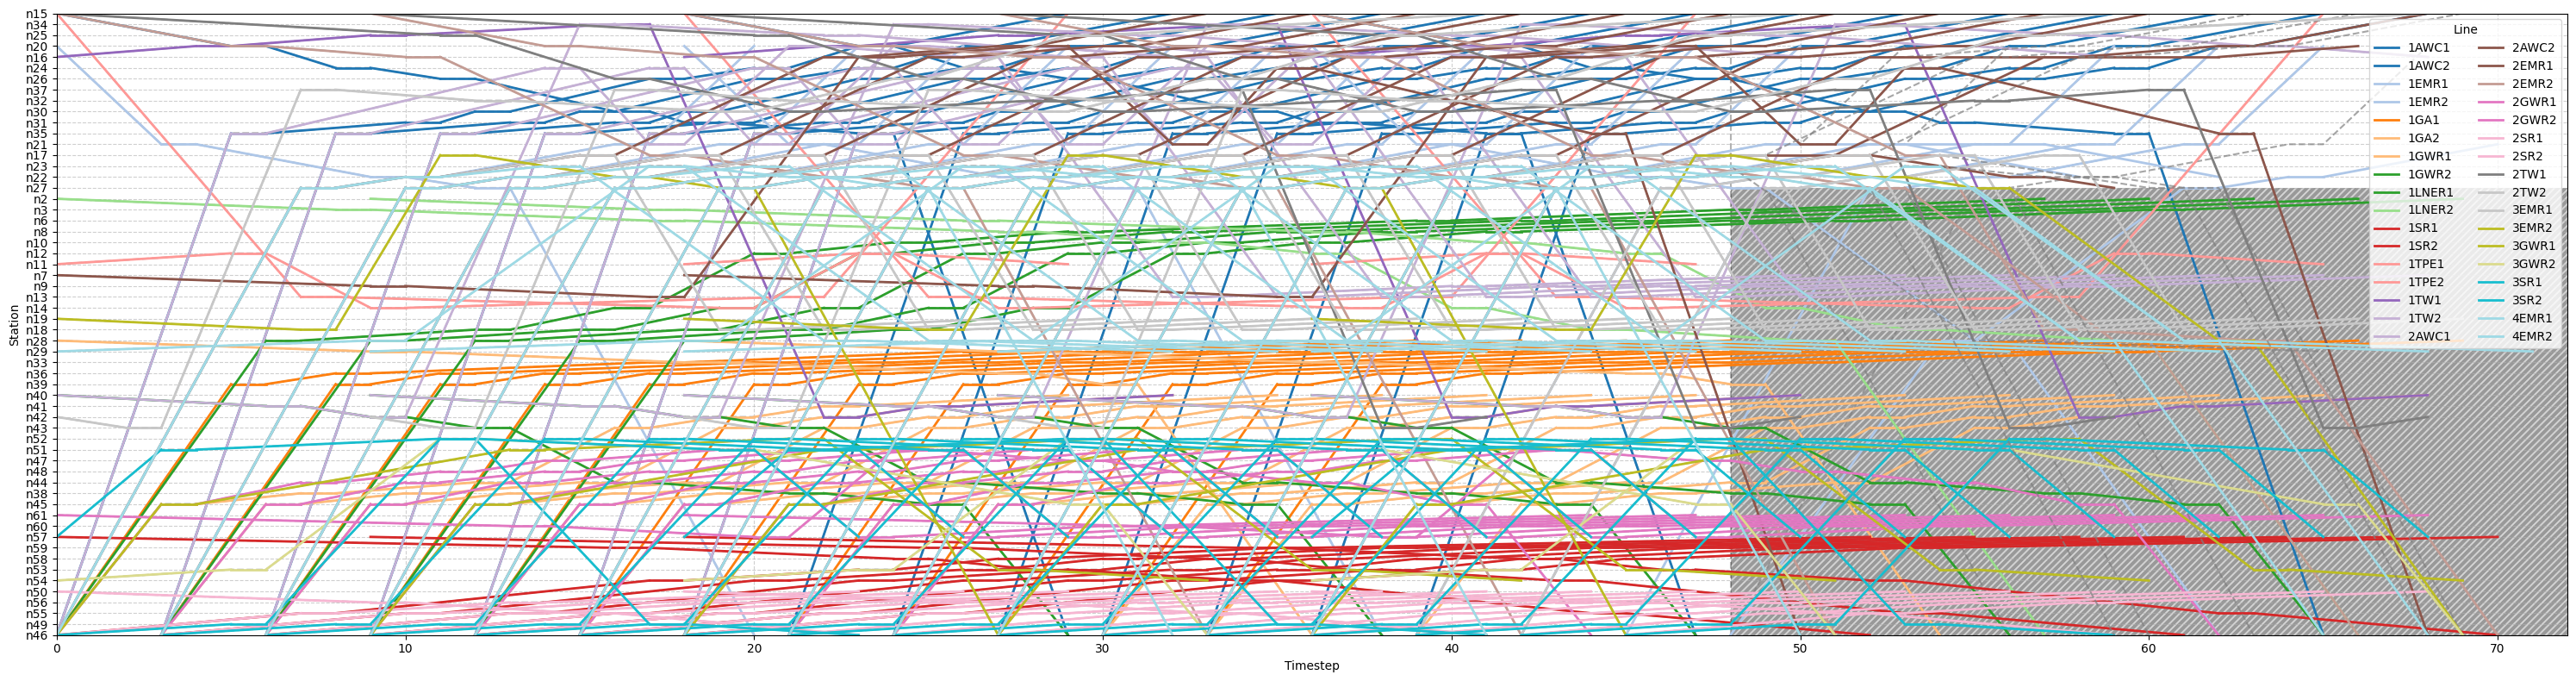

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def route_prefix(tr_id: str):
    return tr_id.rsplit("_", 1)[0] if "_" in tr_id else tr_id

all_route_ids = list(routes_nodes.keys())
global_order = build_canonical_station_order(all_route_ids, routes_nodes)
if not global_order: 
    cnt = Counter(n for seq in routes_nodes.values() for n in seq if n != SINK)
    global_order = [n for n, _ in cnt.most_common()]
station_map_global = {name: i+1 for i, name in enumerate(global_order)}

by_line = defaultdict(list)
for tr in trains:
    by_line[route_prefix(tr)].append(tr)

lines_sorted = sorted(by_line.keys())
cmap = plt.cm.get_cmap("tab20", max(1, len(lines_sorted)))
line_color = {ln: cmap(i % cmap.N) for i, ln in enumerate(lines_sorted)}

def h_get(tr):
    return float(h_final.get(tr, 1.0))

fig, ax = plt.subplots(figsize=(30, 8))

for i, line in enumerate(lines_sorted):
    trs = by_line[line]
    color = line_color[line]
    plot_train_paths(
        trs, ax, title=None,
        h_get=h_get, routes_nodes=routes_nodes, sched=sched,
        station_map=station_map_global, xmax=96,
        color=color, label=line,                 
        failed_edges=failed_edges, edges=edges,
        incident_x0=FAIL_T, incident_x1=T_clear,
        show_incident_line=(i == 0),        
        show_incident_legend=False
    )

ax.set_xlabel("Timestep")
ax.set_ylabel("Station")
plt.xlim(0, 72)
ax.legend(title="Line", ncol=2, frameon=True)
fig.tight_layout()
plt.show()

C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_24840\1933057871.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(1, len(lines_sorted)))


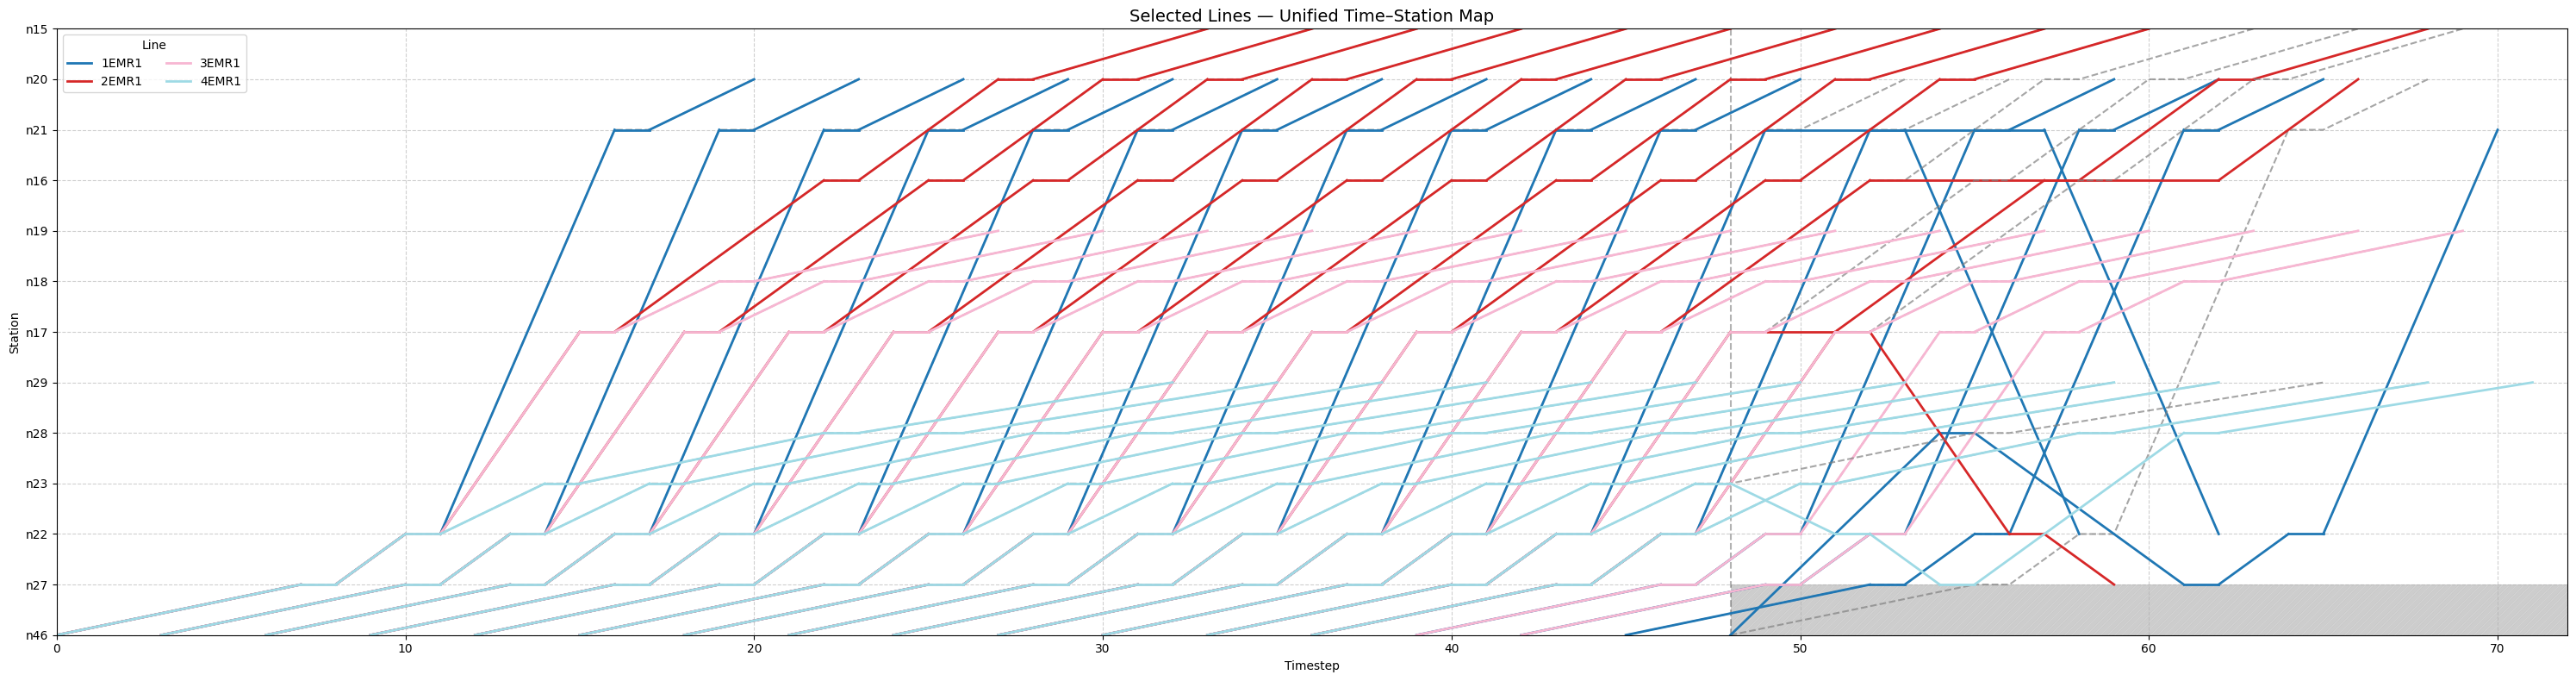

C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_24840\1933057871.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(1, len(lines_sorted)))


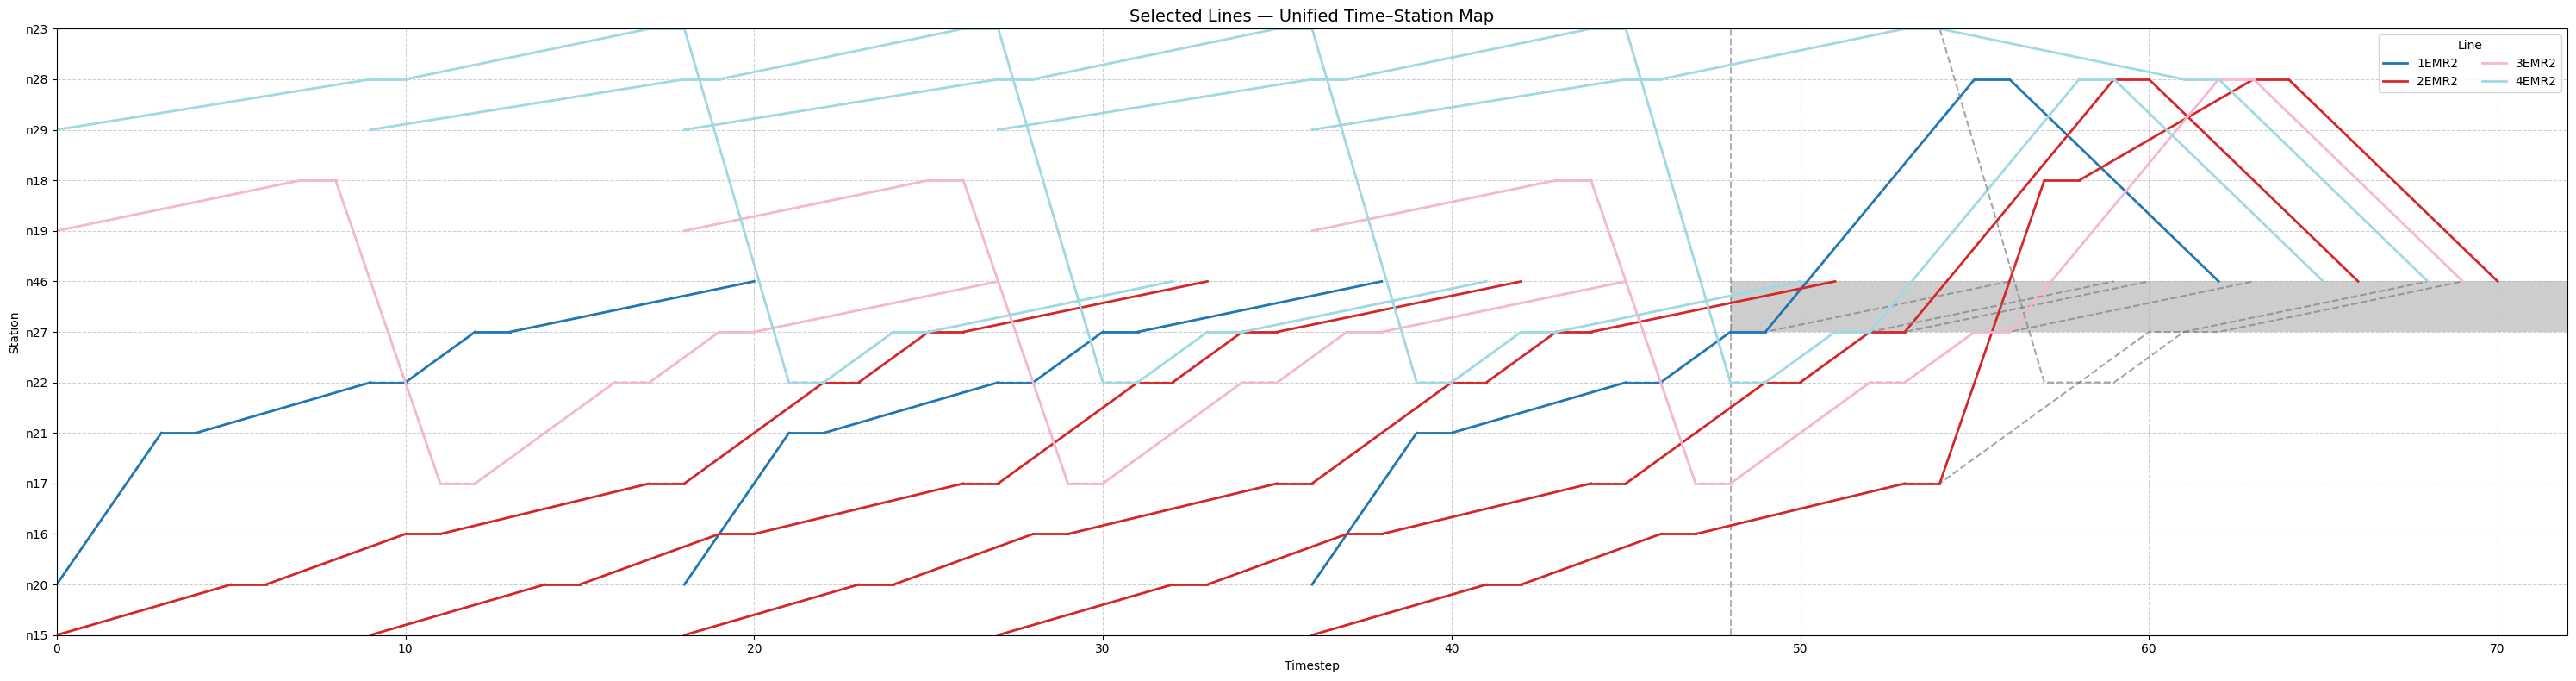

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def route_prefix(tr_id: str):
    return tr_id.rsplit("_", 1)[0] if "_" in tr_id else tr_id

def plot_selected_lines(
    selected_lines,
    xmax=96,
    figsize=(24, 8),
    use_global_order=False,
    show_incident_line=True
):

    selected_lines = [str(x).strip() for x in selected_lines if str(x).strip()]
    if not selected_lines:
        raise ValueError("selected_lines가 비어 있습니다.")

    by_line = defaultdict(list)
    for tr in trains:
        base = route_prefix(tr)
        if base in selected_lines:
            by_line[base].append(tr)

    if not by_line:
        raise ValueError(f"선택된 라인에 해당하는 열차가 없습니다: {selected_lines}")

    if use_global_order and 'station_map_global' in globals():
        station_map = station_map_global
    else:
        sel_trs = [tr for lst in by_line.values() for tr in lst]
        order = build_canonical_station_order(sel_trs, routes_nodes)
        if not order:
            cnt = Counter(n for tr in sel_trs for n in routes_nodes[tr] if n != SINK)
            order = [n for n, _ in cnt.most_common()]
        station_map = {name: i+1 for i, name in enumerate(order)}

    lines_sorted = sorted(by_line.keys())
    cmap = plt.cm.get_cmap("tab20", max(1, len(lines_sorted)))
    line_color = {ln: cmap(i % cmap.N) for i, ln in enumerate(lines_sorted)}

    def h_get(tr):
        return float(h_final.get(tr, 1.0))

    fig, ax = plt.subplots(figsize=figsize)

    for i, line in enumerate(lines_sorted):
        trs = by_line[line]
        color = line_color[line]
        plot_train_paths(
            trs, ax, title=None,
            h_get=h_get,
            routes_nodes=routes_nodes, sched=sched,
            station_map=station_map, xmax=xmax,
            color=color, label=line,             
            failed_edges=failed_edges, edges=edges,
            incident_x0=FAIL_T, incident_x1=T_clear,
            show_incident_line=(show_incident_line and i == 0),
            show_incident_legend=False
        )

    ax.set_title("Selected Lines — Unified Time–Station Map", fontsize=14)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Station")
    ax.set_xlim(0, xmax)
    ax.legend(title="Line", ncol=2, frameon=True)
    fig.tight_layout()
    plt.show()
    return fig, ax

fig, ax = plot_selected_lines(["1EMR1", "2EMR1", "3EMR1", "4EMR1"], xmax=72, figsize=(30,8))
fig, ax = plot_selected_lines(["1EMR2", "2EMR2", "3EMR2", "4EMR2"], xmax=72, figsize=(30,8))

C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_24840\2635328924.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_24840\2635328924.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_24840\2635328924.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` ins

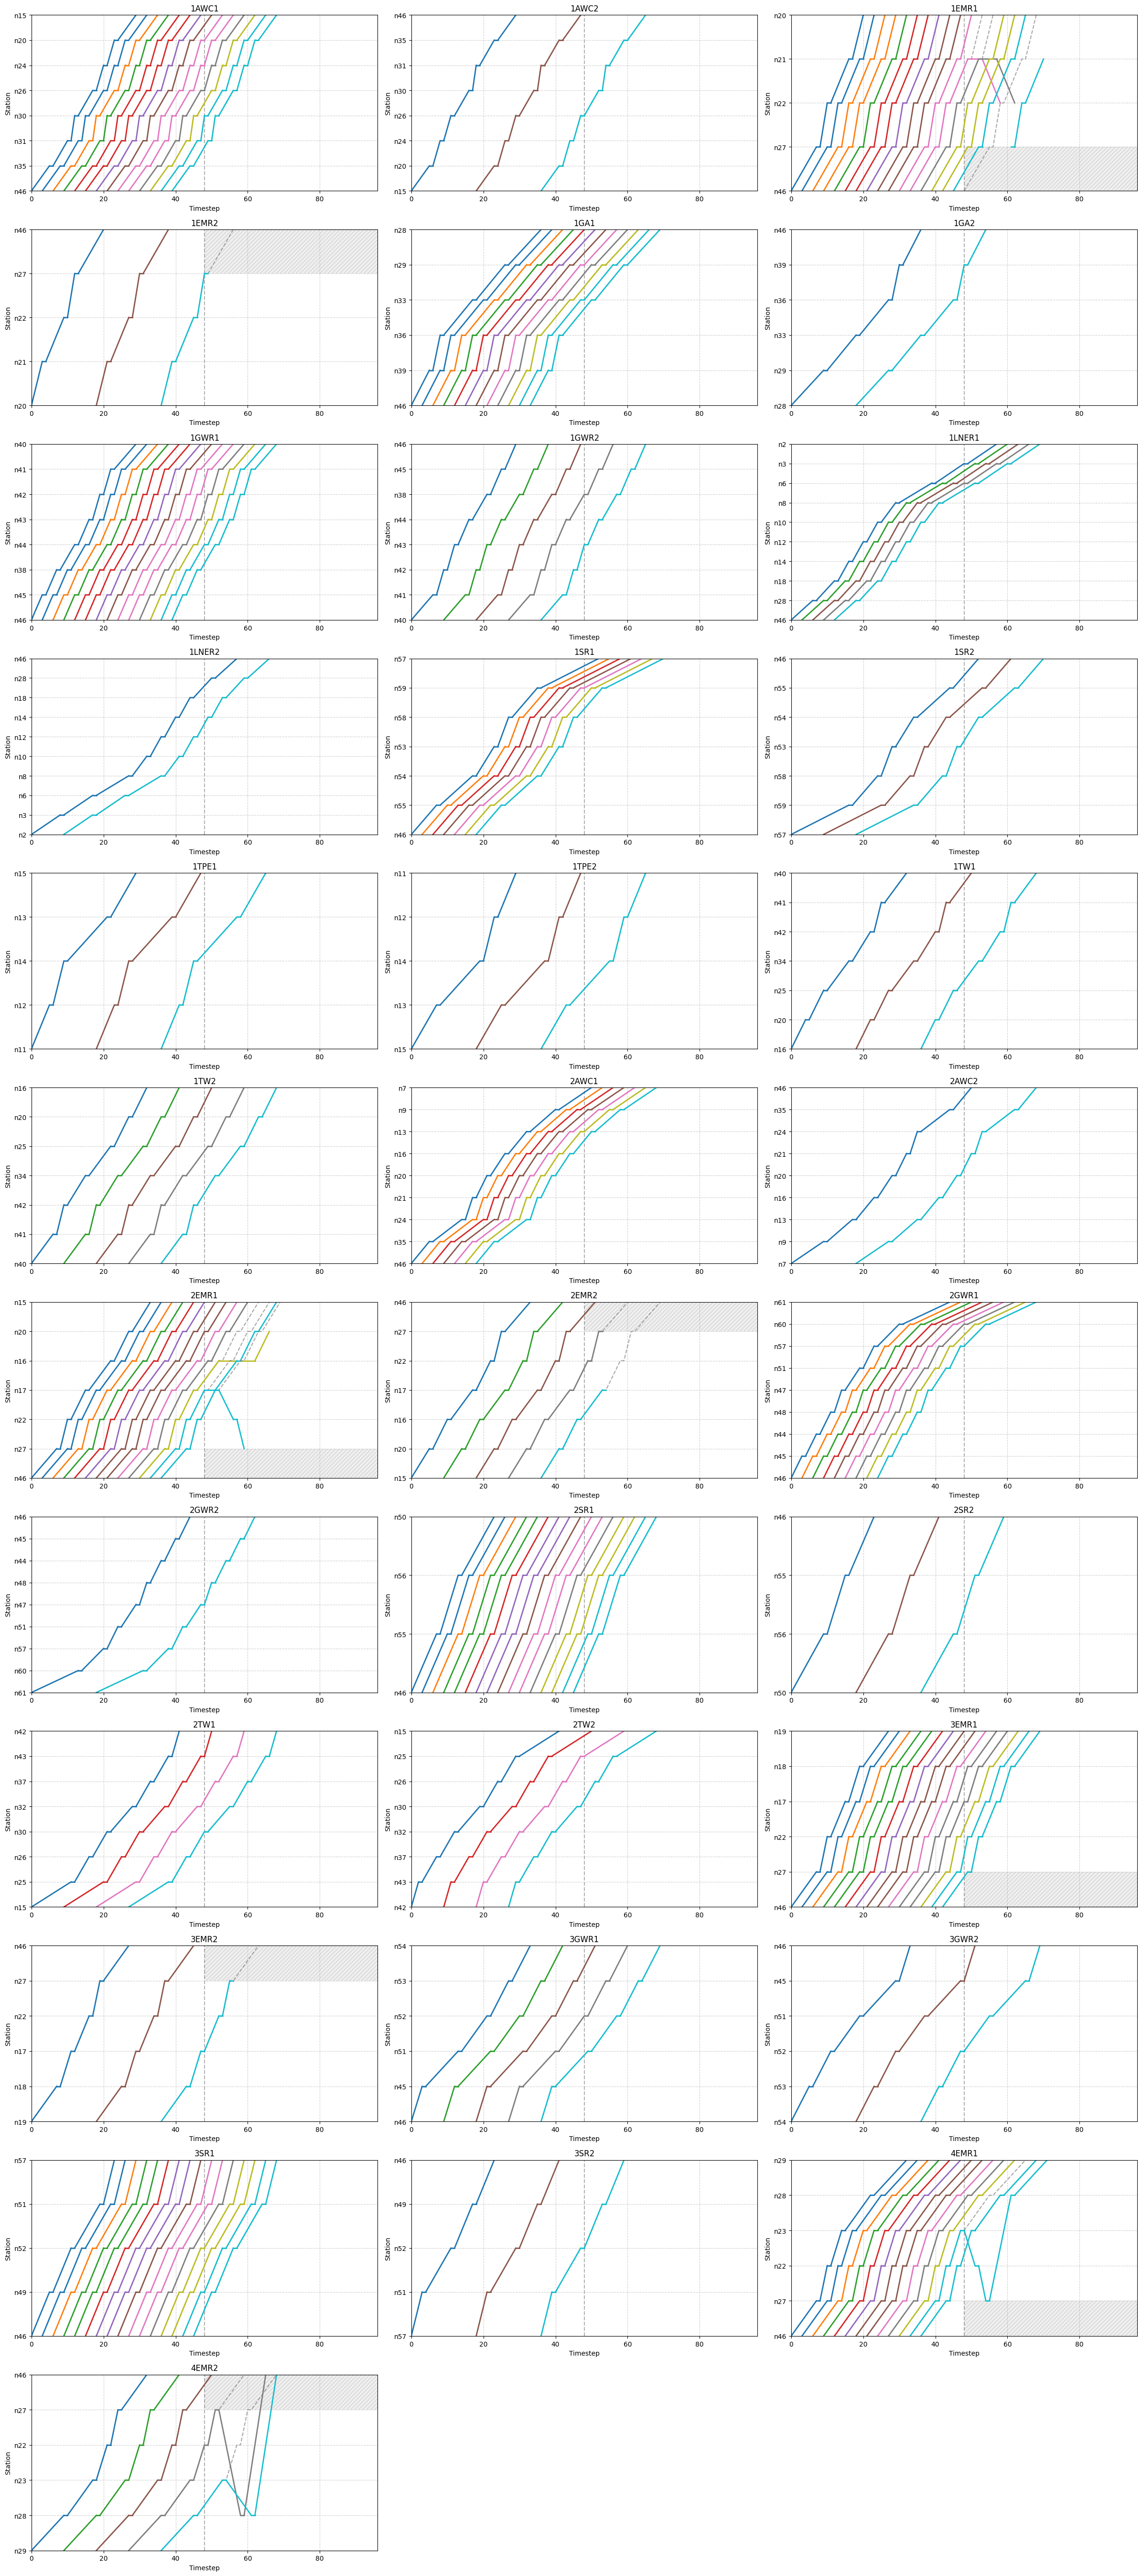

In [ ]:
import math
import matplotlib.pyplot as plt
from collections import defaultdict

def route_prefix(tr_id: str):
    return tr_id.rsplit("_", 1)[0] if "_" in tr_id else tr_id

def h_get(tr):
    return float(h_final.get(tr, 1.0))

by_line = defaultdict(list)
for tr in trains:
    base = route_prefix(tr)
    by_line[base].append(tr)

def build_line_station_map(line_tr_list):
    order = build_canonical_station_order(line_tr_list, routes_nodes)
    if not order:  
        cnt = Counter(n for tr in line_tr_list for n in routes_nodes[tr] if n != SINK)
        order = [n for n, _ in cnt.most_common()]
    station_map = {name: i+1 for i, name in enumerate(order)}
    return station_map, order

xmax = 96  
lines_sorted = sorted(by_line.keys())
n_lines = len(lines_sorted)

n_cols = 2 if n_lines <= 8 else 3
n_rows = math.ceil(n_lines / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 4.5*n_rows), squeeze=False)

for idx, line in enumerate(lines_sorted):
    r, c = divmod(idx, n_cols)
    ax = axes[r][c]
    tr_list = by_line[line]

    station_map, order = build_line_station_map(tr_list)

    plot_train_paths(
        tr_list, ax, title=line,
        h_get=h_get,
        routes_nodes=routes_nodes, sched=sched,
        station_map=station_map, xmax=xmax,
        failed_edges=failed_edges, edges=edges,
        incident_x0=FAIL_T, incident_x1=T_clear,
        show_incident_line=True, show_incident_legend=False  
    )

for k in range(n_lines, n_rows*n_cols):
    r, c = divmod(k, n_cols)
    axes[r][c].axis("off")

fig.tight_layout()
plt.show()